# K-means

In [12]:
import sys
import glob
import pandas as pd
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

sys.path.append('../../../lab')# permite importar modulos locales
sys.path.append('../../../lab/lab4/ej1/src')

In [13]:
from kmeans.k_means import k_means
from kmeans.kmeans_helper import print_results_J, print_results, print_results1

# Implementacioón algoritmo K-Means



Pseudocodigo:

k = número de clusters

1) Inicializar k clusters con sus centroides µ1, µ2, µ3 .... µk de forma aleatoria. 
2) while not converge:
    for i in range(dataset):
        
        ck = argmin|| xi - µk||^2
        
        for j in range(k):
            µj = (∑ 1 {c[i] = j}xi)/ (∑ 1{c[i] = j}) con i= 1..m
            {c[i] = 1} si c[i] = j, 0 en caso contrario)
            
            
Seleccionando k puntos de los datos que van a ser clasificados.
Marcamos que el algoritmo converge cuando los centroides de la iteración anterior coinciden con los centroides actuales, o cuando se supera cierto número de iteraciones.
            

Para la implementación del algoritmo se crearon dos clases auxiliares:

Points: Representa los vectores que van a ser clasificados.

In [ ]:
class Point:

    def __init__(self, coordinates):
        self.coordinates = coordinates
        self.dimension = len(coordinates)

    def __repr__(self):
        return 'Coordinates: ' + str(self.coordinates) + \
               ' -> Dimension: ' + str(self.dimension)
        

Cluster: Representa los clusters generado por el algoritmo. Cada cluster contiene el centroide y los puntos que son asignados luego de la clasificación.


In [ ]:
class Cluster:

    def __init__(self, points):
        if len(points) == 0:
            raise Exception("Cluster cannot have 0 Points")
        else:
            self.points = points
            self.dimension = points[0].dimension

        # Check that all elements of the cluster have the same dimension
        for p in points:
            if p.dimension != self.dimension:
                raise Exception(
                    "Point %s has dimension %d different with %d from the rest "
                    "of points") % (p, len(p), self.dimension)

        # Calculate Centroid
        self.centroid = self.calculate_centroid()
        self.converge = False
        
    def calculate_centroid(self):

        sum_coordinates = np.zeros (self.dimension)
        for p in self.points:
            for i, x in enumerate (p.coordinates):
                sum_coordinates[i] += x

        return (sum_coordinates / len (self.points)).tolist ()  
    
    def update_cluster(self, points):

        old_centroid = self.centroid
        self.points = points
        self.centroid = self.calculate_centroid()
        self.converge = np.array_equal(old_centroid, self.centroid)  


Como se observa en el atributo centroid, se llama al método calculate_centroid() para asignarle el centroide al Cluster en función de la lista de puntos del Cluster. Este método calcula el centroide como el punto medio de todos los puntos que forman el Cluster.

Por otro lado implementamos el método update_cluster(points), que es el método encargado de actualizar el estado del Cluster, calculando el nuevo centroide con los nuevos puntos del Cluster tras el paso de asignación y comprobando si convergen los centroides mirando el valor del centroide del paso anterior y del actual. 

In [ ]:
def k_means(dataset, num_clusters, iterations):

    points = dataset_to_list_points(dataset)

    #J(c,µ) = ∑ || x^(i) - µc^(i)||^2
    #Se inicializan varias veces los centroides y se toma el resultado con menor valor en la funcion de costos
    #para evitar minimos locales

    clusters_cost_min = None
    cost_min = sys.float_info.max

    for i in range(5):
        # INICIALIZACIÓN: Selección aleatoria de N puntos y creación de los Clusters
        initial = random.sample(points, num_clusters)
        clusters = [Cluster([p]) for p in initial]

        # Inicializamos una lista para el paso de asignación de objetos
        new_points_cluster = [[] for i in range(num_clusters)]

        converge = False
        it_counter = 0
        while (not converge) and (it_counter < iterations):
            # ASIGNACION
            for p in points:
                i_cluster = get_nearest_cluster(clusters, p)
                new_points_cluster[i_cluster].append(p)

            # ACTUALIZACIÓN
            for i, c in enumerate(clusters):
                c.update_cluster(new_points_cluster[i])

            # ¿CONVERGE?
            converge = [c.converge for c in clusters].count(False) == 0

            # Incrementamos el contador
            it_counter += 1
            new_points_cluster = [[] for i in range(num_clusters)]

        cost = 0
        for c in clusters:
            cost = cost + c.cost_function()
        if cost < cost_min:
            cost_min = cost
            clusters_cost_min = clusters

Considerando la funcion de costo J(c, µ) = ∑ ||x^(i) - µc^(i)||^2 se inicializan varias veces los centroides para evitar mínimos locales. Luego de realizar varias corridas con los distintos centroides inicializados aleatoriamente nos quedamos con la corrida que mejor valor dio en la función J.

En primer lugar inicializamos ‘N’ Clusters (num_clusteres) seleccionando de forma aleatoria ‘N’ puntos del data set. Posteriormente iniciamos los pasos de asignación y actualización de los Clusters hasta que estos converjan o hasta que lleguemos al número máximo de iteraciones (iterations). Esto lo hacemos dentro del bucle “While”. En cada iteración asignamos cada uno de los puntos del data set al Cluster que tenga el centroide más cercano (Asignación) con el método get_nearest_cluster() que calcula la distancia euclídea entre el punto y el centroide y devuelve el índice del Cluster con centroide más cercano, y una vez asignados recalculamos los centroides de los Clusters. Posteriormente comprobamos la convergencia de los centroides para ver si seguimos iterando o no.

# Evaluación del algoritmo

Para reducir los tiempos de ejecución de las pruebas limitamos la cantidad de features en CountVectorizer a 300.

Luego de ejecutado el algoritmo con la implementación que realizamos y la implementación provista por la librería sklearn, para comparar los resultados por cada cluster generado en la implementación sklearn, buscamos el cluster más cercano generado por nuestra implementación y comparamos la cantidad de puntos que tiene asignado cada cluster.


(63327, 300)
Resultados k= 10: 


  Cluster    Number Points in Cluster sklearn    Number Points in Cluster    Distancia centroides
---------  ----------------------------------  --------------------------  ----------------------
        1                                5161                        4040                0.319437
        2                                9495                        8239                0.331324
        3                                3668                       17561                1.54005
        4                               11515                        3821                1.03355
        5                                4341                        7073                2.04243
        6                                9168                        3130                1.42419
        7                                3604                        2010                1.34426
        8                                4594                        9741                

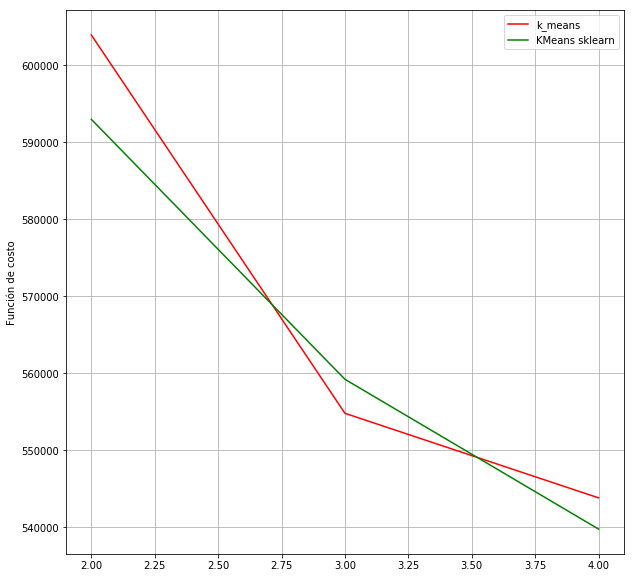

In [14]:
# dataset = load_files ("../datasets",categories=['Health-Tweets'])
# # list of text documents
# text = dataset.data
# vectorizer = CountVectorizer (encoding='latin-1', stop_words='english')
# vector = vectorizer.fit_transform (text)

path = '../datasets/Health-Tweets/*.txt'
filenames = glob.glob (path)
text = []
for fname in filenames:
    with open (fname,encoding='latin-1') as infile:
        for line in infile:
            text.append (line)

vectorizer = CountVectorizer (encoding='latin-1', stop_words='english', max_features=300)
vector = vectorizer.fit_transform (text)

df = pd.DataFrame (data=vector.toarray ())
points = df.as_matrix ().tolist()
print(df.as_matrix ().shape)


J = []
J_sklearn = []
max_iterations =10
n_clusters = 10

for n_clusters in range(10,40, 10):

    clusters = k_means(points, n_clusters, max_iterations, optimize=True)

    kmeans = KMeans (n_clusters=n_clusters, max_iter=max_iterations, init='random')
    kmeans.fit (points)

    # Print final result
    print_results1(kmeans, clusters)

    cost = 0
    for c in clusters:
        cost = cost + c.cost_function ()
    cost_sklearn = kmeans.inertia_
    J.append(cost)
    J_sklearn.append(cost_sklearn)

print_results_J(J, J_sklearn)
